# PM2 — Conditioning and Sensitivity
Team: Camille Wardlaw, Manuel Valencia, Demircan Tas\\
Scope: Tasks C (Conditioning) and D (Sensitivity)

## Overview
- Quick regression sanity, then Conditioning (Task C) and Sensitivity (Task D).
- Task C: focus on steady L — cond vs N, aspect ratio, absorption, invariance, and practical tolerances.
- Task D: dp plateau selection, relative sensitivities per hydrophone, and transient note for α.


## Quick Regression (sanity)

COMPLETE SONAR MODEL TEST SUITE

PART A: MODEL FUNCTIONALITY TESTS

TEST 1: Matrix Dimensions
----------------------------------------
✓ PASSED: Matrix dimensions correct

TEST 2: Zero Input Response
----------------------------------------
✓ PASSED: Zero state remains stable

TEST 3: Source Excitation
----------------------------------------
✓ PASSED: Source generates signal: 9.51e-01 Pa

TEST 4: CFL Condition
----------------------------------------
✓ PASSED: Timestep 0.001241 respects CFL

TEST 5: Hydrophone Configuration
----------------------------------------
✓ PASSED: 5 hydrophones configured

TEST 6: Short-term Stability
----------------------------------------
started running a simple solver, please wait...
✓ PASSED: No immediate divergence

PART B: JACOBIAN TEST BENCH

TEST 7: Linear System Check
----------------------------------------
✓ PASSED: Jacobian equals A matrix (linear system)

TEST 8: Finite Difference Verification
----------------------------------------
  dx = 1.

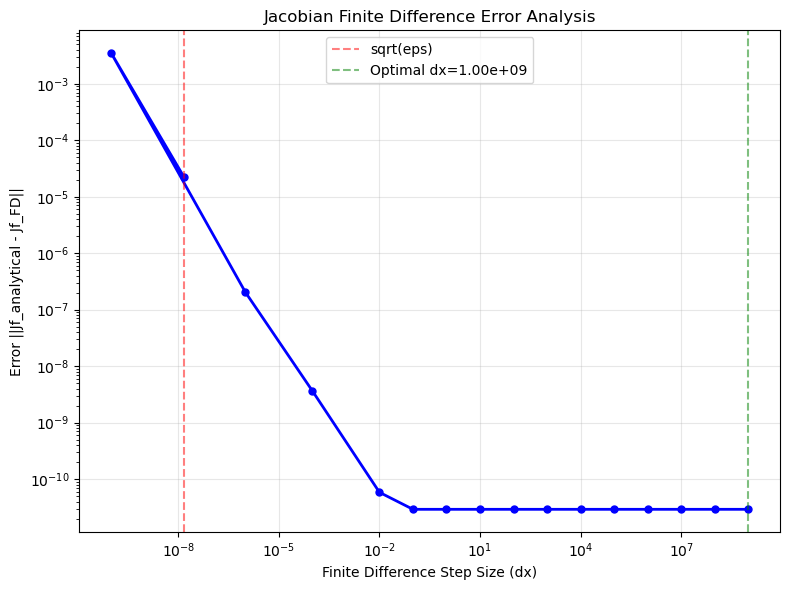


COMPLETE TEST SUMMARY
Total Tests Passed: 10
Total Tests Failed: 0
Overall Success Rate: 100.0%

✓ ALL TESTS PASSED!
PM2 regression summary — passed: 10, failed: 0


In [1]:
from test_Sonar import test_sonar_complete
passed, failed = test_sonar_complete()
print(f'PM2 regression summary — passed: {passed}, failed: {failed}')

## Task D — Setup (helpers)


In [2]:
# Helpers: model I/O and steady QoI
import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve
from getParam_Sonar import getParam_Sonar

def build_C(p):
    H = p['hydrophones']['n_phones']
    Nx, Nz = p['Nx'], p['Nz']
    N = Nx * Nz
    C = np.zeros((H, 2*N))
    z_pos = p['hydrophones']['z_pos']
    for h, x_idx in enumerate(p['hydrophones']['x_indices']):
        if x_idx < Nx:
            k = x_idx * Nz + z_pos
            C[h, k] = 1.0
    return C

def to_dense(A):
    return A.toarray() if sp.issparse(A) else np.array(A)

def extract_L(p):
    Nx, Nz = p['Nx'], p['Nz']
    N = Nx * Nz
    A = p['A']
    Lblk = A[N:, :N]
    return Lblk.toarray() if sp.issparse(Lblk) else np.array(Lblk)

def solve_steady(p, u0=1.0):
    A, B = p['A'], p['B']
    rhs = -(B * float(u0)).toarray().ravel() if sp.issparse(B) else -(B * float(u0)).ravel()
    if sp.issparse(A):
        x = spsolve(A, rhs)
    else:
        x = np.linalg.solve(A, rhs)
    return x.reshape((-1,1))

def rebuild_params_like(p, **overrides):
    q = dict(p)
    is_sparse = sp.issparse(p['A'])
    Nx, Nz = p['Nx'], p['Nz']
    N = Nx * Nz
    A = p['A']
    # Update alpha/c by reconstructing A blocks
    alpha_new = overrides.get('alpha', p['alpha'])
    c_new = overrides.get('c', p['c'])
    c_old = p['c']
    scale = (c_new / c_old)**2 if 'c' in overrides else 1.0
    if is_sparse:
        L_blk = A[N:, :N]
        I_N = sp.eye(N, format='csr')
        L_new = L_blk * scale
        A_new = sp.bmat([[sp.csr_matrix((N, N)), I_N],
                         [L_new, -alpha_new * I_N]], format='csr')
    else:
        L_blk = A[N:, :N]
        I_N = np.eye(N)
        L_new = L_blk * scale
        A_new = np.block([[np.zeros((N, N)), I_N],
                         [L_new, -alpha_new * I_N]])
    q['A'] = A_new
    q['alpha'] = alpha_new
    q['c'] = c_new
    # Update B if sonar position overrides are provided
    si = overrides.get('sonar_ix', p['sonar_ix'])
    sj = overrides.get('sonar_iz', p['sonar_iz'])
    if ('sonar_ix' in overrides) or ('sonar_iz' in overrides):
        def idx(i,j):
            return i * Nz + j
        if is_sparse:
            B = sp.lil_matrix((2*N,1), dtype=float)
            B[N + idx(si,sj), 0] = 1.0 / (p['dx']*p['dz'])
            q['B'] = B.tocsr()
        else:
            B = np.zeros((2*N,1))
            B[N + idx(si,sj), 0] = 1.0 / (p['dx']*p['dz'])
            q['B'] = B
        q['sonar_ix'] = si
        q['sonar_iz'] = sj
    # Optional: rebuild with new absorbing strength (affects L structure)
    if 'absorb_strength' in overrides:
        from getParam_Sonar import getParam_Sonar
        Nx, Nz, Lx, Lz = q['Nx'], q['Nz'], q['Lx'], q['Lz']
        q_new, *_ = getParam_Sonar(Nx, Nz, Lx, Lz, UseSparseMatrices=bool(is_sparse), absorb_strength=overrides['absorb_strength'])
        # Carry over updated alpha/c if present
        q_new['alpha'] = q.get('alpha', q_new['alpha'])
        q_new['c'] = q.get('c', q_new['c'])
        q = q_new
    return q

def compute_y(p, u0=1.0):
    return (build_C(p) @ solve_steady(p, u0=u0)).reshape(-1,1)


## Task C — Extended Analysis (PM2_TaskC-style)

Grid  3x 3 (N=   9, dx=50.000m, dz=50.000m): cond(L) = 9.7141e+00
Grid  4x 4 (N=  16, dx=33.333m, dz=33.333m): cond(L) = 1.7787e+01
Grid  5x 5 (N=  25, dx=25.000m, dz=25.000m): cond(L) = 2.8171e+01
Grid  7x 7 (N=  49, dx=16.667m, dz=16.667m): cond(L) = 5.5871e+01
Grid 10x10 (N= 100, dx=11.111m, dz=11.111m): cond(L) = 1.1473e+02
Grid 15x15 (N= 225, dx=7.143m, dz=7.143m): cond(L) = 2.5913e+02
Grid 20x20 (N= 400, dx=5.263m, dz=5.263m): cond(L) = 4.6151e+02
Grid 25x25 (N= 625, dx=4.167m, dz=4.167m): cond(L) = 7.2191e+02
Grid 30x30 (N= 900, dx=3.448m, dz=3.448m): cond(L) = 1.0404e+03
Grid 40x40 (N=1600, dx=2.564m, dz=2.564m): cond(L) = 1.8514e+03
Grid 50x50 (N=2500, dx=2.041m, dz=2.041m): cond(L) = 2.8947e+03
Grid 60x60 (N=3600, dx=1.695m, dz=1.695m): cond(L) = 4.1703e+03
Grid 70x70 (N=4900, dx=1.449m, dz=1.449m): cond(L) = 5.6781e+03
Grid 80x80 (N=6400, dx=1.266m, dz=1.266m): cond(L) = 7.4181e+03


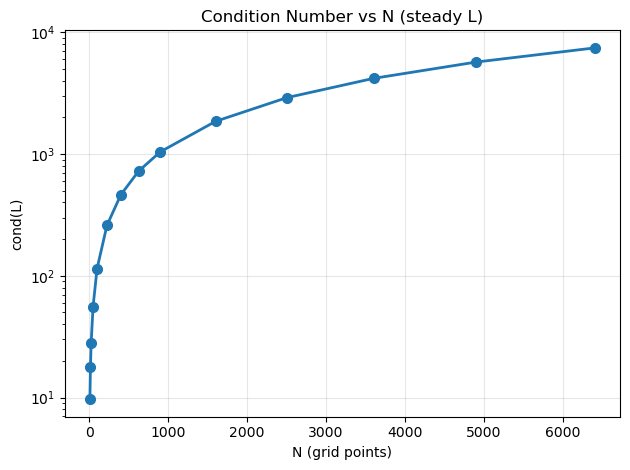

In [3]:

# PM2_TaskC-style: cond(L) vs N with printed summary
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import cond as dense_cond
from getParam_Sonar import getParam_Sonar

def extract_L(p):
    Nx, Nz = p['Nx'], p['Nz']
    N = Nx * Nz
    A = p['A']
    Lblk = A[N:, :N]
    try:
        import scipy.sparse as sp
        return Lblk.toarray() if sp.issparse(Lblk) else np.array(Lblk)
    except Exception:
        return np.array(Lblk)

Lx, Lz = 100, 100
grids_to_test = [(3, 3),(4, 4),(5, 5),(7, 7),(10, 10),(15, 15),(20, 20),(25, 25),(30, 30),(40, 40),(50, 50),(60, 60),(70, 70),(80, 80)]

results = []
for Nx, Nz in grids_to_test:
    p, *_ = getParam_Sonar(Nx, Nz, Lx, Lz, UseSparseMatrices=False)
    L = extract_L(p)
    N = Nx * Nz
    dx = Lx / (Nx - 1)
    dz = Lz / (Nz - 1)
    cond_L = dense_cond(L)
    results.append({'Nx': Nx, 'Nz': Nz, 'N': N, 'dx': dx, 'dz': dz, 'cond_L': cond_L})
    print(f"Grid {Nx:2d}x{Nz:2d} (N={N:4d}, dx={dx:.3f}m, dz={dz:.3f}m): cond(L) = {cond_L:.4e}")

N_vals = [r['N'] for r in results]
cond_vals = [r['cond_L'] for r in results]

plt.figure()
plt.semilogy(N_vals, cond_vals, 'o-', linewidth=2, markersize=7)
plt.xlabel('N (grid points)')
plt.ylabel('cond(L)')
plt.title('Condition Number vs N (steady L)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


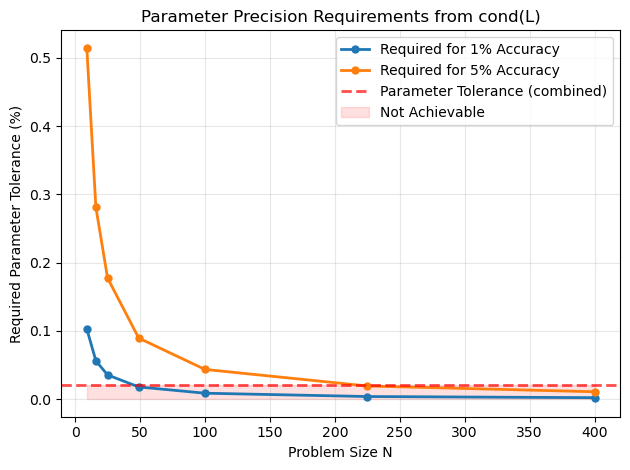

Digits of Trust 
Grid       cond(L)      Numerical       Physical            
     9           10       15.0 digits       2.7 digits
    16           18       14.7 digits       2.4 digits
    25           28       14.6 digits       2.2 digits
    49           56       14.3 digits       1.9 digits
   100          115       13.9 digits       1.6 digits
   225          259       13.6 digits       1.3 digits
   400          462       13.3 digits       1.0 digits
   625          722       13.1 digits       0.8 digits
   900         1040       13.0 digits       0.7 digits
  1600         1851       12.7 digits       0.4 digits
  2500         2895       12.5 digits       0.2 digits
  3600         4170       12.4 digits       0.1 digits
  4900         5678       12.2 digits       0.0 digits
  6400         7418       12.1 digits       0.0 digits


In [4]:

# PM2_TaskC-style: tolerance overlay and digits of trust
import numpy as np
import matplotlib.pyplot as plt

# reuse results from previous cell if present; recompute if not
try:
    N_vals
    cond_vals
except NameError:
    N_vals = []
    cond_vals = []

if not N_vals:
    from numpy.linalg import cond as dense_cond
    from getParam_Sonar import getParam_Sonar
    def extract_L(p):
        Nx, Nz = p['Nx'], p['Nz']
        N = Nx * Nz
        A = p['A']
        Lblk = A[N:, :N]
        try:
            import scipy.sparse as sp
            return Lblk.toarray() if sp.issparse(Lblk) else np.array(Lblk)
        except Exception:
            return np.array(Lblk)
    Lx, Lz = 100, 100
    results = []
    for Nx, Nz in [(5,5),(10,10),(15,15),(20,20),(25,25),(30,30),(40,40)]:
        p, *_ = getParam_Sonar(Nx, Nz, Lx, Lz, UseSparseMatrices=False)
        L = extract_L(p)
        N = Nx * Nz
        cond_L = dense_cond(L)
        N_vals.append(N)
        cond_vals.append(cond_L)

combined = np.sqrt((0.006)**2 + (0.02)**2)  # example: 0.6% (CTD) and 2% other

plt.figure()
num_show = len(N_vals)//2 if len(N_vals) > 2 else len(N_vals)
tol_1 = [(0.01 / c) * 100 for c in cond_vals]
tol_5 = [(0.05 / c) * 100 for c in cond_vals]
plt.plot(N_vals[:num_show], tol_1[:num_show], 'o-', linewidth=2, markersize=5, label='Required for 1% Accuracy', color='C0')
plt.plot(N_vals[:num_show], tol_5[:num_show], 'o-', linewidth=2, markersize=5, label='Required for 5% Accuracy', color='C1')
plt.axhline(combined, color='r', linestyle='--', linewidth=2, alpha=0.7, label='Parameter Tolerance (combined)')
plt.fill_between(N_vals[:num_show], 0, [combined]*num_show, alpha=0.12, color='red', label='Not Achievable')
plt.xlabel('Problem Size N')
plt.ylabel('Required Parameter Tolerance (%)')
plt.title('Parameter Precision Requirements from cond(L)')
plt.legend()
plt.grid(True, which='both', alpha=0.3)
plt.tight_layout()
plt.show()

print("Digits of Trust ")
print(f"{'Grid':<10s} {'cond(L)':<12s} {'Numerical':<15s} {'Physical':<20s}")
for N, cL in zip(N_vals, cond_vals):
    # Numerical precision (perfect parameters)
    digits_num = 16 - np.log10(cL)
    # Physical precision (with param uncertainty)
    err_phys = cL * combined/100
    digits_phys = -np.log10(err_phys) if err_phys < 1 else 0
    print(f"{N:6d}     {cL:8.0f}     {digits_num:6.1f} digits    {digits_phys:6.1f} digits")


Grid size effect...
  Grid 10x10 (N=  100): cond = 1.15e+02
  Grid 15x15 (N=  225): cond = 2.59e+02
  Grid 20x20 (N=  400): cond = 4.62e+02
  Grid 25x25 (N=  625): cond = 7.22e+02
  Grid 30x30 (N=  900): cond = 1.04e+03
  Grid 40x40 (N= 1600): cond = 1.85e+03
  Grid 50x50 (N= 2500): cond = 2.89e+03
 Aspect ratio effect (fixed N=400)...
  Grid 100x  4: dx/dz=  0.03, cond=7.77e+03
  Grid  50x  8: dx/dz=  0.14, cond=1.94e+03
  Grid  40x 10: dx/dz=  0.23, cond=1.26e+03
  Grid  25x 16: dx/dz=  0.62, cond=5.71e+02
  Grid  20x 20: dx/dz=  1.00, cond=4.62e+02
  Grid  16x 25: dx/dz=  1.60, cond=6.08e+02
  Grid  10x 40: dx/dz=  4.33, cond=1.44e+03
  Grid   8x 50: dx/dz=  7.00, cond=2.26e+03
  Grid   4x100: dx/dz= 33.00, cond=9.85e+03


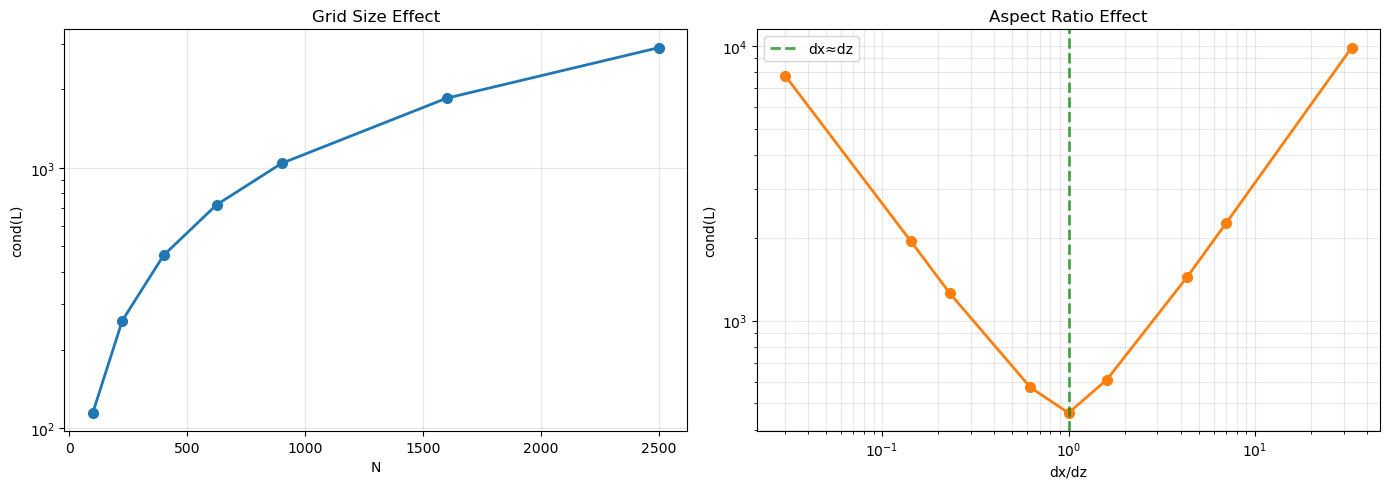

In [5]:

# PM2_TaskC-style: Grid size vs cond, and Aspect ratio effect at fixed N
import numpy as np
import matplotlib.pyplot as plt
from getParam_Sonar import getParam_Sonar

def extract_L(p):
    Nx, Nz = p['Nx'], p['Nz']
    N = Nx * Nz
    A = p['A']
    Lblk = A[N:, :N]
    try:
        import scipy.sparse as sp
        return Lblk.toarray() if sp.issparse(Lblk) else np.array(Lblk)
    except Exception:
        return np.array(Lblk)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

print("Grid size effect...")
grid_sizes = [(10,10), (15,15), (20,20), (25,25), (30,30), (40,40), (50,50)]
Lx, Lz = 100, 100
N_vals, cond_vals = [], []
for Nx, Nz in grid_sizes:
    p, *_ = getParam_Sonar(Nx, Nz, Lx, Lz, UseSparseMatrices=False)
    L = extract_L(p)
    N = Nx * Nz
    kappa = np.linalg.cond(L)
    N_vals.append(N)
    cond_vals.append(kappa)
    print(f"  Grid {Nx}x{Nz} (N={N:5d}): cond = {kappa:.2e}")
ax1.semilogy(N_vals, cond_vals, 'o-', linewidth=2, markersize=7, color='C0')
ax1.set_xlabel('N')
ax1.set_ylabel('cond(L)')
ax1.set_title('Grid Size Effect')
ax1.grid(True, alpha=0.3)

print(" Aspect ratio effect (fixed N=400)...")
aspect_configs = [(100,4),(50,8),(40,10),(25,16),(20,20),(16,25),(10,40),(8,50),(4,100)]
aspect_vals, cond_aspect = [], []
for Nx, Nz in aspect_configs:
    p, *_ = getParam_Sonar(Nx, Nz, Lx, Lz, UseSparseMatrices=False)
    L = extract_L(p)
    dx, dz = Lx/(Nx-1), Lz/(Nz-1)
    aspect = dx/dz
    kappa = np.linalg.cond(L)
    aspect_vals.append(aspect)
    cond_aspect.append(kappa)
    print(f"  Grid {Nx:3d}x{Nz:3d}: dx/dz={aspect:6.2f}, cond={kappa:.2e}")
ax2.loglog(aspect_vals, cond_aspect, 'o-', linewidth=2, markersize=7, color='C1')
ax2.axvline(1.0, color='g', linestyle='--', linewidth=2, alpha=0.7, label='dx≈dz')
ax2.set_xlabel('dx/dz')
ax2.set_ylabel('cond(L)')
ax2.set_title('Aspect Ratio Effect')
ax2.legend(); ax2.grid(True, which='both', alpha=0.3)
plt.tight_layout(); plt.show()


Absorb =   0.10  cond(L) = 1.8183e+03
Absorb =   0.50  cond(L) = 5.8732e+02
Absorb =   1.00  cond(L) = 4.4958e+02
Absorb =   1.50  cond(L) = 4.1393e+02
Absorb =   2.00  cond(L) = 4.0421e+02
Absorb =   2.50  cond(L) = 4.0523e+02
Absorb =   3.00  cond(L) = 4.1183e+02
Absorb =   5.00  cond(L) = 4.6151e+02
Absorb =  10.00  cond(L) = 6.2824e+02
Absorb =  20.00  cond(L) = 9.8972e+02
Absorb =  50.00  cond(L) = 2.0966e+03
Absorb = 100.00  cond(L) = 3.9489e+03


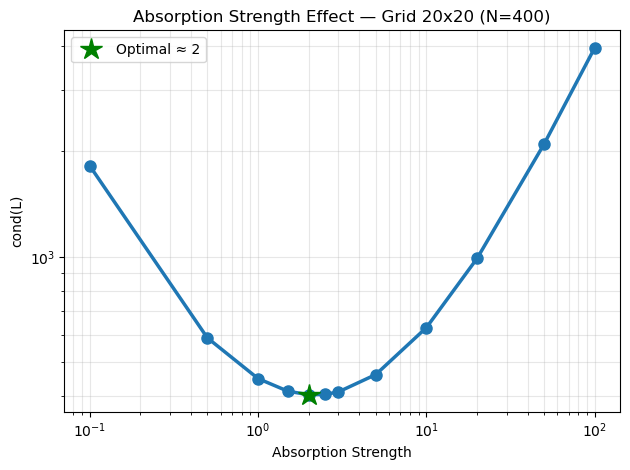

In [6]:

# PM2_TaskC-style: Absorption strength sweep
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import cond as dense_cond
from getParam_Sonar import getParam_Sonar

def extract_L(p):
    Nx, Nz = p['Nx'], p['Nz']
    N = Nx * Nz
    A = p['A']
    Lblk = A[N:, :N]
    try:
        import scipy.sparse as sp
        return Lblk.toarray() if sp.issparse(Lblk) else np.array(Lblk)
    except Exception:
        return np.array(Lblk)

Lx, Lz = 100, 100
Nx, Nz = 20, 20
abs_vals = [0.1, 0.5, 1, 1.5, 2, 2.5, 3, 5, 10, 20, 50, 100]
records = []
for ab in abs_vals:
    p, *_ = getParam_Sonar(Nx, Nz, Lx, Lz, UseSparseMatrices=False, absorb_strength=ab)
    L = extract_L(p)
    kappa = dense_cond(L)
    records.append((ab, kappa))
    print(f"Absorb = {ab:6.2f}  cond(L) = {kappa:.4e}")

absorb_vals = [r[0] for r in records]
cond_vals = [r[1] for r in records]
plt.figure()
plt.loglog(absorb_vals, cond_vals, 'o-', linewidth=2.5, markersize=8, color='C0')
min_idx = int(np.argmin(cond_vals))
plt.plot(absorb_vals[min_idx], cond_vals[min_idx], 'g*', markersize=16, label=f"Optimal ≈ {absorb_vals[min_idx]}")
plt.xlabel('Absorption Strength'); plt.ylabel('cond(L)')
plt.title(f'Absorption Strength Effect — Grid {Nx}x{Nz} (N={Nx*Nz})')
plt.grid(True, which='both', alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()



### What does not affect cond(L) (steady)
- Uniform domain scaling `(Lx,Lz) → (aLx,aLz)` — only scalar scaling, cond invariant
- Changing `c` or `α` — `L` scales, and cond is scale‑invariant


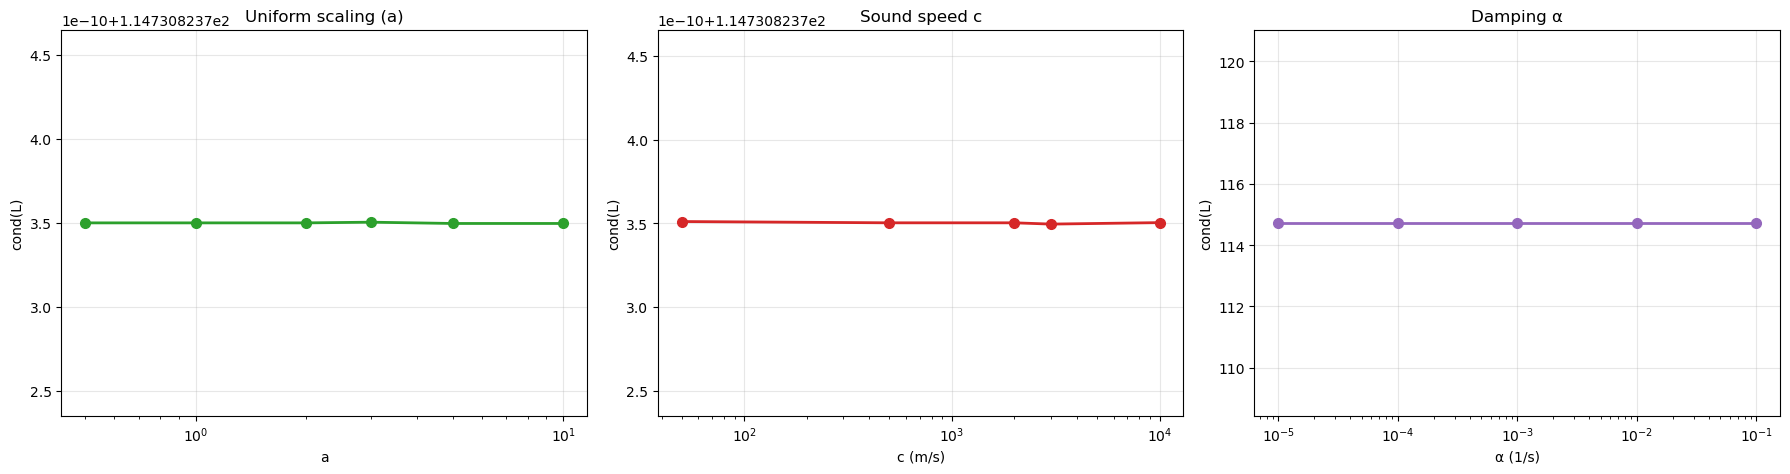

In [7]:

# PM2_TaskC-style: Invariance checks (uniform scaling, c, alpha)
import numpy as np
import matplotlib.pyplot as plt
from getParam_Sonar import getParam_Sonar

def extract_L(p):
    Nx, Nz = p['Nx'], p['Nz']
    N = Nx * Nz
    A = p['A']
    Lblk = A[N:, :N]
    try:
        import scipy.sparse as sp
        return Lblk.toarray() if sp.issparse(Lblk) else np.array(Lblk)
    except Exception:
        return np.array(Lblk)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# Uniform domain scaling
Nx, Nz = 10, 10
scale_factors = [0.5, 1.0, 2.0, 3.0, 5.0, 10.0]
cond_scaling = []
for a in scale_factors:
    Lx, Lz = 10*a, 10*a
    p0, *_ = getParam_Sonar(Nx, Nz, Lx, Lz, UseSparseMatrices=True)
    kappa = np.linalg.cond(extract_L(p0))
    cond_scaling.append(kappa)
ax1.semilogx(scale_factors, cond_scaling, 'o-', linewidth=2, markersize=7, color='C2')
ax1.set_title('Uniform scaling (a)'); ax1.set_xlabel('a'); ax1.set_ylabel('cond(L)'); ax1.grid(True, alpha=0.3)

# Sound speed (scale invariance)
Nx, Nz, Lx, Lz = 10, 10, 100, 100
p0, *_ = getParam_Sonar(Nx, Nz, Lx, Lz, UseSparseMatrices=True)
L0 = extract_L(p0)
c0 = p0['c']
c_values = [50, 500, 2000, 3000, 10000]
cond_c = []
for c_val in c_values:
    scale = (c_val / c0)**2
    kappa = np.linalg.cond(L0 * scale)
    cond_c.append(kappa)
ax2.semilogx(c_values, cond_c, 'o-', linewidth=2, markersize=7, color='C3')
ax2.set_title('Sound speed c'); ax2.set_xlabel('c (m/s)'); ax2.set_ylabel('cond(L)'); ax2.grid(True, alpha=0.3)

# Damping alpha (no effect on L)
alpha_values = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
cond_alpha = []
for a in alpha_values:
    cond_alpha.append(np.linalg.cond(L0))
ax3.semilogx(alpha_values, cond_alpha, 'o-', linewidth=2, markersize=7, color='C4')
ax3.set_title('Damping α'); ax3.set_xlabel('α (1/s)'); ax3.set_ylabel('cond(L)'); ax3.grid(True, alpha=0.3)

plt.tight_layout(); plt.show()


Now break (very fine grid, poor aspect ratio) and recover by coarsening, squaring the grid, and tuning absorbing strength.

## Task D — Enhanced dp selection and sensitivities

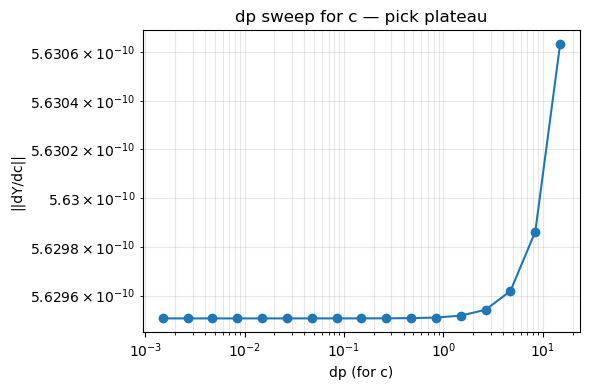

Recommended dp for c (plateau heuristic): 8.435e-03


In [8]:
# dp sweep for finite-difference sensitivity and plateau detection
import numpy as np
import matplotlib.pyplot as plt

# Assumes helpers (build_C, solve_steady, rebuild_params_like) and compute_y() are defined above.
from getParam_Sonar import getParam_Sonar

def fd_sens_norm(p, pname, dp):
    y0 = compute_y(p)

    if pname in ('sonar_ix','sonar_iz'):
        # one-grid-step change for index parameters
        step = int(np.sign(dp) or 1)
        y1 = compute_y(rebuild_params_like(p, **{pname: int(p[pname]) + step}))
        dY = (y1 - y0) / 1.0
    else:
        pp = rebuild_params_like(p, **{pname: p[pname] + dp})
        pm = rebuild_params_like(p, **{pname: p[pname] - dp})
        dY = (compute_y(pp) - compute_y(pm)) / (2*dp)
    return float(np.linalg.norm(dY))

def sweep_dp(p, pname, dp_values):
    vals = []
    for dp in dp_values:
        try:
            vals.append(fd_sens_norm(p, pname, dp))
        except Exception:
            vals.append(np.nan)
    return np.array(vals)

# Demonstration: dp plateau for c
Nx, Nz, Lx, Lz = 20, 10, 100, 50
p, *_ = getParam_Sonar(Nx, Nz, Lx, Lz, UseSparseMatrices=True)

dp_c = np.logspace(-6, -2, 17) * p['c']
vals_c = sweep_dp(p, 'c', dp_c)

plt.figure(figsize=(6,4))
plt.loglog(dp_c, vals_c, 'o-')
plt.xlabel('dp (for c)'); plt.ylabel('||dY/dc||')
plt.title('dp sweep for c — pick plateau')
plt.grid(True, which='both', alpha=0.3); plt.tight_layout(); plt.show()

logx = np.log10(dp_c); logy = np.log10(vals_c)
slope = np.gradient(logy, logx)
idx = int(np.nanargmin(np.abs(slope)))
dp_rec_c = dp_c[idx]
print(f'Recommended dp for c (plateau heuristic): {dp_rec_c:.3e}')


c: recommended dp = 6.962e-03


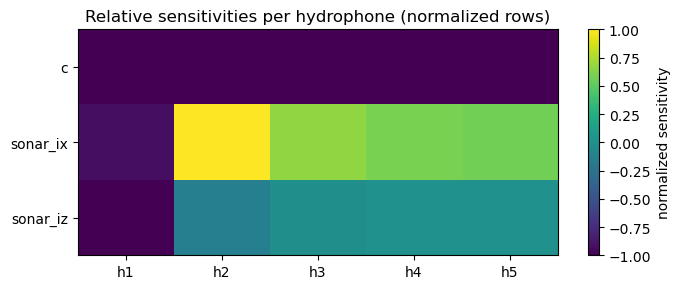

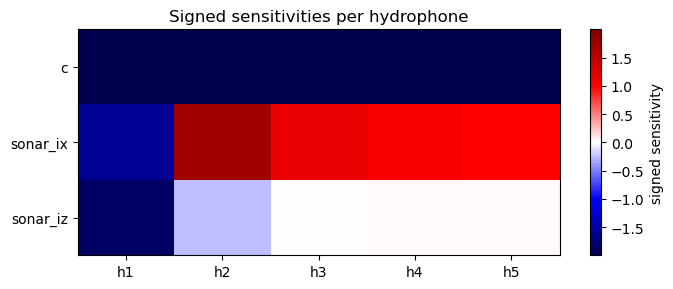

In [9]:

# Relative sensitivities across parameters using recommended dp
import numpy as np
import matplotlib.pyplot as plt

def pick_dp(dp_vals, vals):
    # robust plateau finder on log-log; fallback to median if all-NaN/inf/zero
    dp_vals = np.asarray(dp_vals)
    vals = np.asarray(vals)
    m = np.isfinite(dp_vals) & np.isfinite(vals) & (vals > 0)
    if np.count_nonzero(m) >= 3:
        lx, ly = np.log10(dp_vals[m]), np.log10(vals[m])
        slope = np.gradient(ly, lx)
        k_rel = int(np.nanargmin(np.abs(slope)))
        return dp_vals[m][k_rel]
    # fallback: mid dp
    return np.median(dp_vals)

# Parameters to assess
params = ['c']  # absorb_strength moved to Task C; keep Task D focused on physics/source
dp_map = {}
for pname in params:
    if pname == 'c':
        dp_vals = np.logspace(-6, -2, 13) * p['c']
    else:
        dp_vals = np.logspace(-4, 0, 13)
    vals = sweep_dp(p, pname, dp_vals)
    dp_map[pname] = pick_dp(dp_vals, vals)
    print(f"{pname}: recommended dp = {dp_map[pname]:.3e}")

def relative_sensitivity(p, pname, dp):
    y0 = compute_y(p).flatten(); eps = 1e-16
    y0abs = np.abs(y0) + eps
    if pname in ('sonar_ix','sonar_iz'):
        y1 = compute_y(rebuild_params_like(p, **{pname: int(p[pname])+1})).flatten()
        dY = (y1 - y0)/1.0
        pscale = (p['dx'] if pname=='sonar_ix' else p['dz'])
    else:
        pp = rebuild_params_like(p, **{pname: p[pname] + dp})
        pm = rebuild_params_like(p, **{pname: p[pname] - dp})
        dY = (compute_y(pp).flatten() - compute_y(pm).flatten())/(2*dp)
        pscale = abs(p[pname]) if p[pname] != 0 else 1.0
    rel = (dY / y0abs) * pscale
    return rel

# Build per-hydrophone sensitivities for chosen parameters + source indices
names = params + ['sonar_ix','sonar_iz']
dp_map.update({'sonar_ix': 1, 'sonar_iz': 1})

S = []
for pname in names:
    rel = relative_sensitivity(p, pname, dp_map[pname])
    S.append(rel)
S = np.vstack(S)

# Heatmap (normalized rows)
S_norm = S / (np.linalg.norm(S, ord=np.inf, axis=1, keepdims=True) + 1e-16)
plt.figure(figsize=(7,3))
plt.imshow(S_norm, aspect='auto', cmap='viridis')
plt.colorbar(label='normalized sensitivity')
plt.yticks(range(len(names)), names)
plt.xticks(range(S.shape[1]), [f"h{i+1}" for i in range(S.shape[1])])
plt.title('Relative sensitivities per hydrophone (normalized rows)')
plt.tight_layout(); plt.show()

# Signed heatmap (not normalized)
plt.figure(figsize=(7,3))
plt.imshow(S, aspect='auto', cmap='seismic', vmin=-np.max(np.abs(S)), vmax=np.max(np.abs(S)))
plt.colorbar(label='signed sensitivity')
plt.yticks(range(len(names)), names)
plt.xticks(range(S.shape[1]), [f"h{i+1}" for i in range(S.shape[1])])
plt.title('Signed sensitivities per hydrophone')
plt.tight_layout(); plt.show()


Transient QoI note: α affects dynamics (peak |y(t)|) — retain PM2 transient section to demonstrate this, while steady QoI masks α sensitivity.

## Transient QoI — α effect (peak hydrophone amplitude)

Running Leapfrog solver (stable for wave equations)...
Bootstrapping with first step...
Running 106 leapfrog steps...
  Progress: 9.3%
  Progress: 18.7%
  Progress: 28.0%
  Progress: 37.4%
  Progress: 46.7%
  Progress: 56.1%
  Progress: 65.4%
  Progress: 74.8%
  Progress: 84.1%
  Progress: 93.5%
Leapfrog integration complete!
Running Leapfrog solver (stable for wave equations)...
Bootstrapping with first step...
Running 106 leapfrog steps...
  Progress: 9.3%
  Progress: 18.7%
  Progress: 28.0%
  Progress: 37.4%
  Progress: 46.7%
  Progress: 56.1%
  Progress: 65.4%
  Progress: 74.8%
  Progress: 84.1%
  Progress: 93.5%
Leapfrog integration complete!
Running Leapfrog solver (stable for wave equations)...
Bootstrapping with first step...
Running 106 leapfrog steps...
  Progress: 9.3%
  Progress: 18.7%
  Progress: 28.0%
  Progress: 37.4%
  Progress: 46.7%
  Progress: 56.1%
  Progress: 65.4%
  Progress: 74.8%
  Progress: 84.1%
  Progress: 93.5%
Leapfrog integration complete!
Running Leapfrog

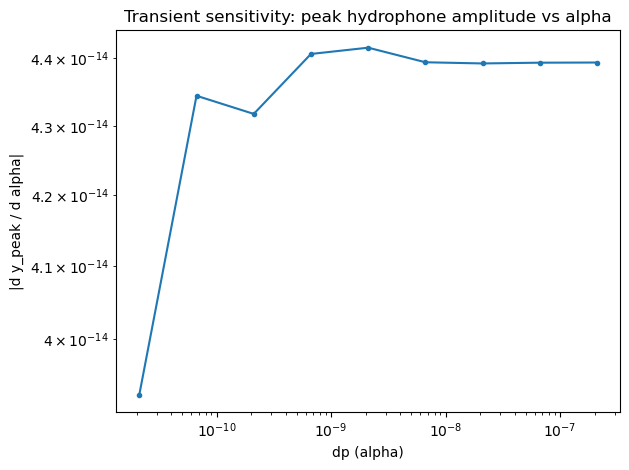

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
from simpleLeapFrog import LeapfrogSolver
from eval_f_Sonar import eval_f_Sonar
from eval_u_Sonar import eval_u_Sonar
from eval_g_Sonar import eval_g_Sonar

import math

# Use a short leapfrog run; define QoI as max |y(t)| across hydrophones
def peak_hydrophone_amplitude(p, num_iter, dt):
    # Use baseline x_start from fresh params to align shapes
    q, x_start, _, _, _ = getParam_Sonar(p['Nx'], p['Nz'], p['Lx'], p['Lz'], UseSparseMatrices=sp.issparse(p['A']))
    # copy A/B from p (may be modified by rebuild_params_like)
    q['A'] = p['A']; q['B'] = p['B']; q['alpha'] = p['alpha']; q['c'] = p['c']
    X, t = LeapfrogSolver(eval_f_Sonar, x_start, q, eval_u_Sonar, num_iter, dt, visualize=False)
    peak = 0.0
    for i in range(len(t)):
        y = eval_g_Sonar(X[:, i], q)
        peak = max(peak, float(np.max(np.abs(y))))
    return peak

Nx, Nz, Lx, Lz = 20, 10, 100, 50
p, x0, t0, t1, dt_max = getParam_Sonar(Nx, Nz, Lx, Lz, UseSparseMatrices=True)
dt = dt_max * 0.5
num_iter = int(max(10, (t1 - t0) / dt))

eps = np.finfo(float).eps
base_alpha = math.sqrt(2*eps) * max(1.0, abs(p['alpha']))
dp_sweep = base_alpha * (10.0 ** np.linspace(-3, 1, 9))

y0_peak = peak_hydrophone_amplitude(p, num_iter, dt)
sens = []
for dp in dp_sweep:
    p_pert = rebuild_params_like(p, alpha=p['alpha'] + dp)
    y1_peak = peak_hydrophone_amplitude(p_pert, num_iter, dt)
    sens.append(abs((y1_peak - y0_peak) / dp))

plt.loglog(dp_sweep, sens, '.-')
plt.xlabel('dp (alpha)')
plt.ylabel('|d y_peak / d alpha|')
plt.title('Transient sensitivity: peak hydrophone amplitude vs alpha')
plt.tight_layout(); plt.show()


## Conclusions
- Summarize conditioning trends vs alpha/grid.
- Report stable dp ranges and most influential parameters.
- Note pitfalls (e.g., low damping, boundary extremes).